<a href="https://colab.research.google.com/github/surendiran-20cl/Titanic-ML-from-Disaster-Kaggle/blob/main/Titanic_ML_from_Disaster_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The "Titanic - Machine Learning from Disaster" Kaggle competition is a classic beginner-friendly project that demonstrates core machine learning concepts like data cleaning, feature engineering, model building, and evaluation.

#  Step 1: Install Required Libraries

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn

# Step 2: Import Libraries


In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Save the model
import joblib

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')


# Step 3: Load the data

In [ ]:
# Load datasets
train_df = pd.read_csv('/content/drive/MyDrive/Kaggle Competitions/Titanic ML from Disaster/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle Competitions/Titanic ML from Disaster/test.csv')

# Preview
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Step 4: Exploratory Data Analysis

In [ ]:
# Basis info
print(train_df.info())
print(train_df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

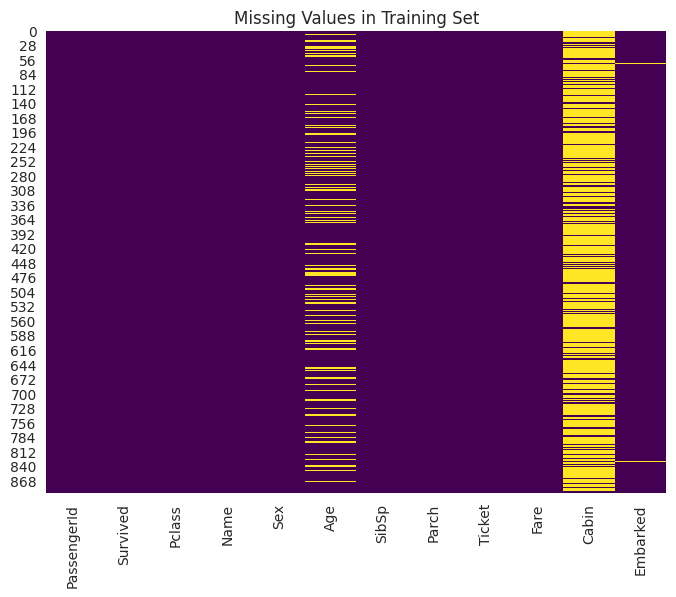

In [ ]:
# Checking missing values
plt.figure(figsize=(8,6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title('Missing Values in Training Set')
plt.show()


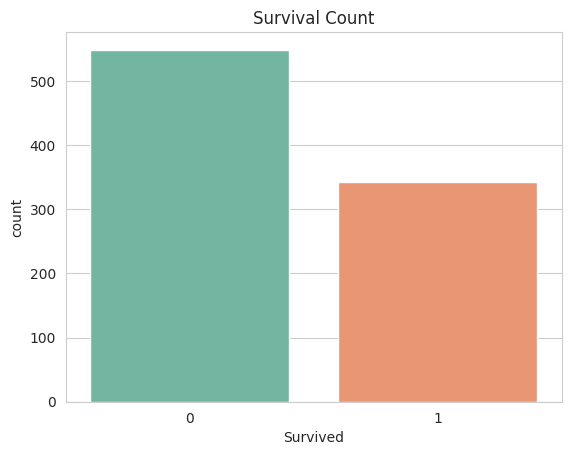

In [ ]:
# Visualize Survival count
sns.countplot(data=train_df, x='Survived', palette='Set2')
plt.title('Survival Count')
plt.show()


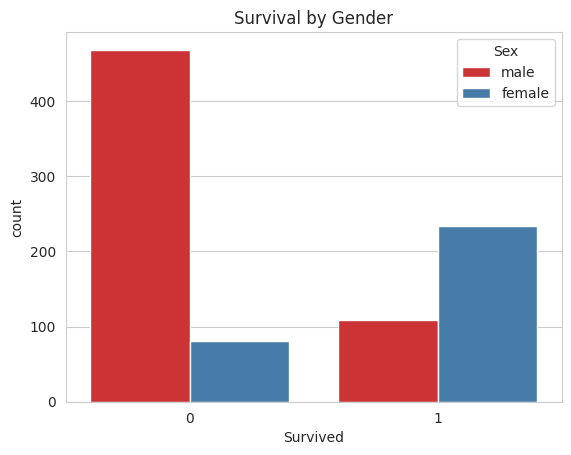

In [ ]:
# Check survival by gender
sns.countplot(data=train_df, x='Survived', hue='Sex', palette='Set1')
plt.title('Survival by Gender')
plt.show()


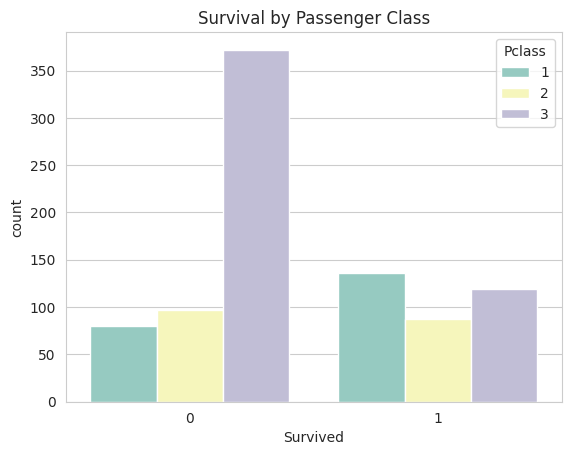

In [ ]:
# Check survival by class
sns.countplot(data=train_df, x='Survived', hue='Pclass', palette='Set3')
plt.title('Survival by Passenger Class')
plt.show()


# Step 5: Data Preprocessing & Feature Engineering

Combine train and test for uniform processing

In [ ]:
data = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)


In [ ]:
# Checking missing values
data.isnull().sum()


,0
PassengerId,0
Survived,418
Pclass,0
Name,0
Sex,0
Age,263
SibSp,0
Parch,0
Ticket,0
Fare,1


In [ ]:
# Fill missing Age with median grouped by Pclass and Sex
data['Age'] = data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))


In [ ]:
# Fill missing Embarked with mode
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)


In [ ]:
# Fill missing Fare with median
data['Fare'].fillna(data['Fare'].median(), inplace=True)

In [ ]:
# Drop Cabin because it has too many missing values
data.drop(columns=['Cabin'], inplace=True)

Feature Engineering

In [ ]:
# Extract Title from Name
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify rare titles
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
       'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')


In [ ]:
# create family size
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1


In [ ]:
# Create isAlone
data['IsAlone'] = 1 # initialize
data.loc[data['FamilySize'] > 1, 'IsAlone'] = 0


Convert Categorical Values

In [ ]:
# Label Encoding

label = LabelEncoder()

data['Sex'] = label.fit_transform(data['Sex'])
data['Embarked'] = label.fit_transform(data['Embarked'])
data['Title'] = label.fit_transform(data['Title'])

In [ ]:
# Select features for model
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked',
            'Title', 'FamilySize', 'IsAlone']

X = data.loc[:len(train_df)-1, features]
y = train_df['Survived']
X_test = data.loc[len(train_df):, features]


# Step 6: Model Building

In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Validation
y_pred = model.predict(X_val)

print('Accuracy:', accuracy_score(y_val, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_val, y_pred))
print('\nClassification Report:\n', classification_report(y_val, y_pred))


Accuracy: 0.8491620111731844

Confusion Matrix:
 [[92 13]
 [14 60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87       105
           1       0.82      0.81      0.82        74

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



In [ ]:
# Cross validation
cv_scores = cross_val_score(model, X, y, cv=5)
print('Cross-Validation Accuracy:', cv_scores.mean())


Cross-Validation Accuracy: 0.8002510827945514


# Step 7: Feature Importance


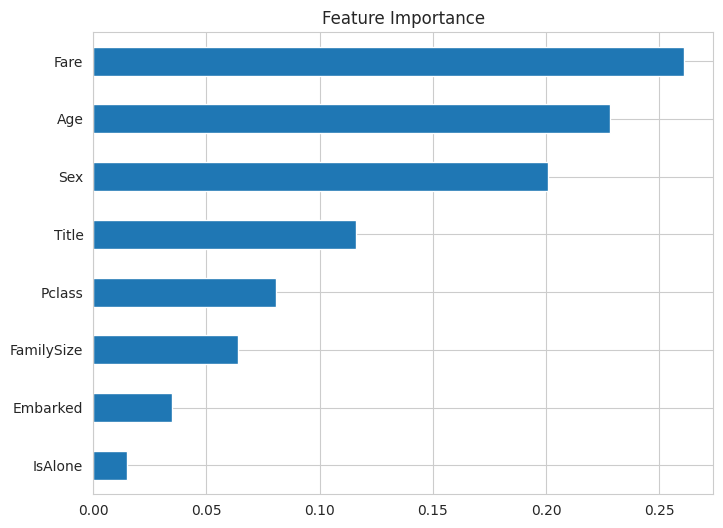

In [ ]:
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title('Feature Importance')
plt.show()


#Step 8: Make predictions on Test data

In [ ]:
predictions = model.predict(X_test)

output = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': predictions
})

output.to_csv('submission.csv', index=False)
print('Submission file created successfully!')


Submission file created successfully!


# Step 9: Save the model



In [ ]:
import os

# Create the directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(model, 'models/titanic_model.pkl')
print('Model saved!')

Model saved!


In [ ]:
#Step-by-Step Deployment using Streamlit on Hugging Face Spaces


# Step 1: Save the Trained Model from Google Colab

# Save your model as a .pkl file:

import joblib

# Save the model
joblib.dump(model, 'titanic_model.pkl')

# Download the file to your local machine
from google.colab import files
files.download('titanic_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>